# Определение возраста покупателей

## Исследовательский анализ данных

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import seaborn as sns

from tensorflow.keras.layers import Dense, AvgPool2D, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50

In [2]:
data = pd.read_csv('/datasets/faces/labels.csv')

Посмотрим общую информацию о предоставленных данных

In [3]:
def df_info(data):
    print('Размерность таблицы:', data.shape) 
    print('----------------------------------')
    display(data.head(10))
    print('----------------------------------')
    display(data.describe())
    print('----------------------------------')
    data.info()
    print('----------------------------------')
    print('Пропусков в таблице:', data.isna().sum())

In [4]:
df_info(data)

Размерность таблицы: (7591, 2)
----------------------------------


,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17
5,000005.jpg,27
6,000006.jpg,24
7,000007.jpg,43
8,000008.jpg,26
9,000009.jpg,39


----------------------------------


,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


----------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB
----------------------------------
Пропусков в таблице: file_name    0
real_age     0
dtype: int64


**Вывод** 
Пропуски отсутствуют, данные готовы к работе
Мы имеем 7591 троку - это количество фотографий лиц людей разного возраста, такое количество на мой взгляд вполнеподойдет для  обучения модели, так в жизни людей можно поделить на 5-7 возрастных категорий, и получается в среднем по 1000-1500 фотографий на подобную группу

Text(0.5, 0, 'Возраст')

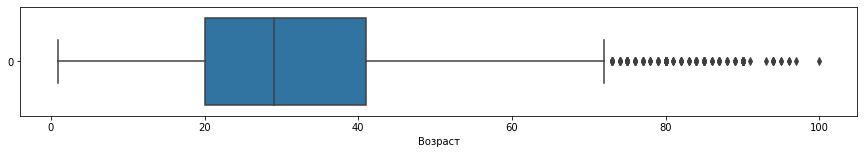

In [5]:
plt.figure(figsize=[15, 2])
sns.boxplot(data=data['real_age'], orient='h')
plt.xlabel('Возраст')

медианна по количеству фотографиу примерна у возраста 30 лет, после 70 лет наблюдаются выбросы данных

In [6]:
def age_group(row):

    age = row['real_age']
    

    if age < 18:
        return 'дети(до 18 лет)'
    if 18 <= age < 35:
        return 'молодеж(с 18 до 35)'
    if 35 <= age < 60:
        return 'зрелый( с 35 до 60)'
    if age >= 60:
        return 'пенсионер старше 60'   

    

In [7]:
data['group'] = data.apply(age_group, axis=1)

In [8]:
data

,file_name,real_age,group
0,000000.jpg,4,дети(до 18 лет)
1,000001.jpg,18,молодеж(с 18 до 35)
2,000002.jpg,80,пенсионер старше 60
3,000003.jpg,50,зрелый( с 35 до 60)
4,000004.jpg,17,дети(до 18 лет)
...,...,...,...
7586,007608.jpg,14,дети(до 18 лет)
7587,007609.jpg,37,зрелый( с 35 до 60)
7588,007610.jpg,28,молодеж(с 18 до 35)
7589,007611.jpg,20,молодеж(с 18 до 35)


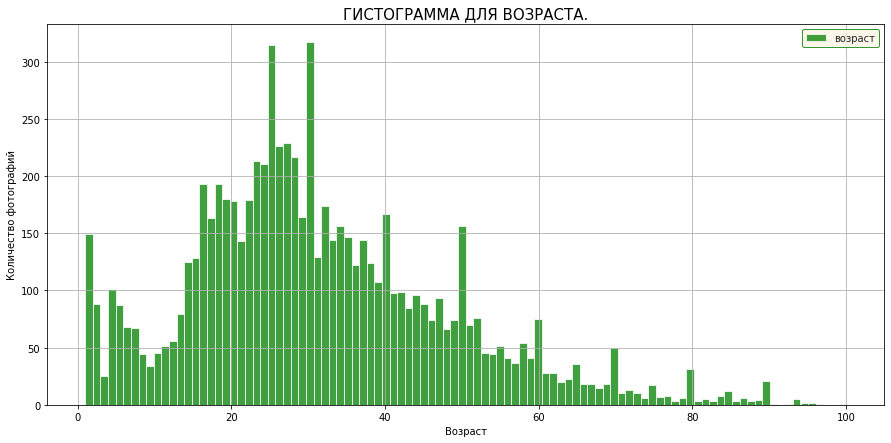

In [9]:
plt.figure(figsize=[15, 7])

plt.title('ГИСТОГРАММА ДЛЯ ВОЗРАСТА.', fontsize=15)
sns.set_style('ticks')
sns.histplot(data=data['real_age'], color = 'g', label='возраст',bins=100, kde=False)
plt.xlabel('Возраст')
plt.ylabel('Количество фотографий')
plt.grid(True)
plt.legend(edgecolor = 'g', facecolor = 'oldlace')
plt.show();

In [10]:
train_datagen = ImageDataGenerator(rescale = 1./255)
train_datagen_flow = train_datagen.flow_from_dataframe(dataframe=data,
                                                      directory='/datasets/faces/final_files/',
                                                      x_col='file_name',
                                                      y_col='real_age',
                                                      target_size=(224,224),
                                                      batch_size=32,
                                                      class_mode='raw',
                                                      seed = 12345)

Found 7591 validated image filenames.


In [11]:
features, target = next(train_datagen_flow)
print('Размер выборки -', features.shape)

Размер выборки - (32, 224, 224, 3)


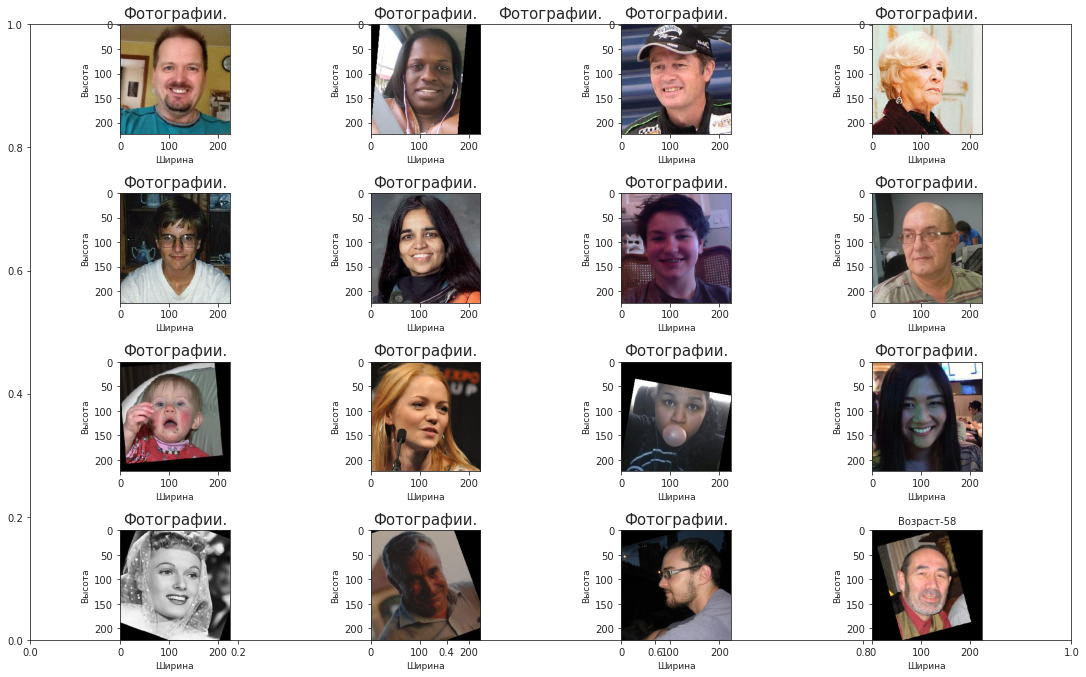

In [12]:
fig = plt.figure(figsize=(15,10))
plt.subplots_adjust(top=0.90, wspace=0.3, hspace=0.95)
for i in range(16):
    plt.title('Фотографии.', fontsize=15)
    fig.add_subplot(4,4, i+1)
    plt.title(f'Возраст-{target[i]}', fontsize=10)
    plt.imshow(features[i])
    plt.grid(False)
    plt.ylabel('Высота', fontsize=9)
    plt.xlabel('Ширина', fontsize=9)
plt.tight_layout()

**Вывод**

Изучив данные мы видим: больше всего фотографиу у возрастной группы от 18 до 35 лет, остальных данных меньше
после 60 лет количество фотографий выглядит как выбросы

Для возрастной группы до 18 лет фотографий значительно меньше, чем от основной группы для продажи, что может плохо повлиять на обучение модели 

Так же можно заметить что присутствуют как цветные фотографии, так и чернобелые

Ориентация фотографий стандартная, поэтому дополнительных действий со смещением не потребуется

Все имеющиеся фотографии одного масштаба

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

    def load_train(path):
        labels = pd.read_csv(path+ 'labels.csv')
        train_datagen = ImageDataGenerator(rescale=1/255.,
                                           validation_split=0.25,
                                           horizontal_flip=True,
                                           )
    
        train_datagen_flow = train_datagen.flow_from_dataframe(dataframe=labels,
                                                          directory=path +'final_files/',    
                                                          x_col='file_name',
                                                          y_col='real_age',
                                                          target_size=(224,224),
                                                          batch_size=32,
                                                          class_mode='raw',
                                                          subset='training',  
                                                          seed = 12345)
        return train_datagen_flow
    
    
    def load_test(path):
        labels = pd.read_csv(path+ 'labels.csv')
        test_datagen = ImageDataGenerator(rescale=1/255.,
                                          validation_split=0.25)
        test_datagen_flow = test_datagen.flow_from_dataframe(dataframe=labels,
                                                             directory=path +'final_files/',    
                                                             x_col='file_name',
                                                             y_col='real_age',
                                                             target_size=(224,224),
                                                             batch_size=32,                                                     
                                                             class_mode='raw',
                                                             subset='validation',     
                                                             seed = 12345)
        return test_datagen_flow
    
    
    def create_model(input_shape):
    
        optimizer = Adam(learning_rate = 0.0001)
        backbone = ResNet50(input_shape=input_shape,
                            weights='imagenet', 
                            include_top=False)
    
    
        model = Sequential()
    
        model.add(backbone)    
        model.add(GlobalAveragePooling2D())  
        model.add(Dense(units=1, activation='relu'))
    
        model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])
        return model
     
    def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                   steps_per_epoch=None, validation_steps=None):
        if steps_per_epoch is None:
            steps_per_epoch = len(train_data)
        if validation_steps is None:
            validation_steps = len(test_data)
        model.fit(train_data,
                  validation_data=test_data,
                  batch_size=batch_size, 
                  epochs=epochs,
                  steps_per_epoch=steps_per_epoch,
                  validation_steps=validation_steps,
                  verbose=2, shuffle=True)
        return model

**Результат работы модели**

Found 5694 validated image filenames.

Found 1897 validated image filenames.


Train for 178 steps, validate for 60 steps

Epoch 1/10

2023-01-07 21:19:12.404328: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10

2023-01-07 21:19:12.695931: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7


178/178 - 47s - loss: 243.9540 - mae: 11.0827 - val_loss: 798.8182 - val_mae: 23.3515

Epoch 2/10

178/178 - 38s - loss: 78.6326 - mae: 6.6772 - val_loss: 821.0774 - val_mae: 23.6644

Epoch 3/10

178/178 - 38s - loss: 49.9044 - mae: 5.3812 - val_loss: 306.5614 - val_mae: 12.8610

Epoch 4/10

178/178 - 38s - loss: 34.4755 - mae: 4.5140 - val_loss: 104.4525 - val_mae: 7.7884

Epoch 5/10

178/178 - 38s - loss: 26.7613 - mae: 3.9295 - val_loss: 87.0414 - val_mae: 7.2433

Epoch 6/10

178/178 - 38s - loss: 22.9677 - mae: 3.6208 - val_loss: 97.9292 - val_mae: 7.7974

Epoch 7/10

178/178 - 38s - loss: 17.5854 - mae: 3.2163 - val_loss: 78.1718 - val_mae: 6.8449

Epoch 8/10

178/178 - 37s - loss: 13.9977 - mae: 2.8848 - val_loss: 63.0463 - val_mae: 5.9088

Epoch 9/10

178/178 - 37s - loss: 11.3825 - mae: 2.5924 - val_loss: 62.7012 - val_mae: 6.0061

Epoch 10/10

178/178 - 37s - loss: 10.6327 - mae: 2.5129 - val_loss: 63.0506 - val_mae: 5.9985

WARNING:tensorflow:sample_weight modes were coerced from

...

to  

['...']

60/60 - 9s - loss: 63.0506 - mae: 5.9985

Test MAE: 5.9985


Модель обучена, с результатом MAE = 5.9985, что ниже 8, как требуется по заданию

## Анализ обученной модели

**Вывод**
Для подготовки данных к обучению модели, к исходным данным мною были применены такие методы как: Аугментация, алгоритм `Adam` с частотой обучения `lr = 0.0001`, а так же архитектуру RestNet50 с параметром `epochs=10`

Все эти методы по итогу выдали результат **`MAE = 5.995`**

**А значит выбранная модель подходит для поставленной цели** **`Определение возраста покупателей`** , что бы Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;

Врятли данная модель подойдет для определения возраста для продажи алкоголя, нехватает данных более молодого возраста.